### Generating and Plotting 2D Swiss roll in 3D

In [2]:
from src.generate_data import generate_dataset
from src.make_plots import plot_swiss_roll_3d

# Step 1: Generate swiss roll
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=3,        # We want 2D swiss roll in 3D
    noise_sigma=0.1,
    random_state=42,
)

X = data["X"]   # (5000, 3)
u = data["u"]   # (5000,) parameter, nice for coloring

# Step 2: Plot swiss roll
fig = plot_swiss_roll_3d(X, color=u, title="Swiss Roll")
fig.show()


### Generating and Plotting 2D Swiss Roll in 10D

In [3]:
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=10, # Embed in 10D
    random_state=0,
)

X_10 = data["X"]
X_3 = X_10[:, :3]  # quick projection for plotting
fig = plot_swiss_roll_3d(X_3, color=data["u"])
fig.show()


In [8]:
from src.generate_data import generate_dataset
from src.manifold_learning import estimate_tangent_normal_knn_pca
from src.make_plots import plot_swiss_with_local_frames_3d

# 1. Generate swiss roll in 3D
data = generate_dataset(
    name="swiss_roll",
    n_samples=2000,
    embed_dim=3,
    noise_sigma=0.0,
    random_state=0,
)

X = data["X"]  # (N, 3)

# 2. Estimate local tangent/normal frames via KNN + PCA
frames = estimate_tangent_normal_knn_pca(
    X,
    intrinsic_dim=2,   # swiss roll is 2D
    n_neighbors=32,
    include_self=True,
)

# 3. Plot swiss roll with tangent planes and normals
fig = plot_swiss_with_local_frames_3d(
    frames,
    every_n=700,           # draw a frame every 50 points
    plane_scale=2,
    normal_scale=10,
    title="Learned tangent planes + normals",
)
fig.show()

# Metrics for the plane the itself... 
# How accurate is the KNN plane (compare vs true tangent plane)?


In [5]:
from src.generate_data import generate_dataset
from src.manifold_learning import estimate_tangent_normal_knn_pca
from src.diffusion import DiffusionExperiment

# 1. Data
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=3,
    noise_sigma=0.0,
    random_state=0,
)
X = data["X"]

# 2. Manifold frames
frames = estimate_tangent_normal_knn_pca(
    X,
    intrinsic_dim=2,
    n_neighbors=32,
    include_self=True,
)

# 3. Diffusion with manifold-aware noise
exp = DiffusionExperiment(
    X=X,
    local_frames=frames,
    tangent_fraction=1.0,
    normal_fraction=0.0,
    mixed_noise=True,
    num_timesteps=1000,
    batch_size=128,
    lr=1e-3,
)

exp.diffusion_train(num_epochs=5)
samples = exp.sample(num_samples=1000)


Epoch 1: loss = 0.815841
Epoch 2: loss = 0.661321
Epoch 3: loss = 0.545173
Epoch 4: loss = 0.542065
Epoch 5: loss = 0.531249


In [5]:
from src.metrics import chamfer_distance, swiss_roll_manifold_distance
import numpy as np
# samples: (N_gen, D) torch.Tensor from exp.sample()
samples_np = samples.cpu().numpy()

# 1) Unknown-manifold metric: dataset vs samples
cd = chamfer_distance(X_true=X, X_gen=samples_np)
print("Chamfer distance:", cd)

# 2) Known-manifold metric for swiss roll
md = swiss_roll_manifold_distance(
    X_gen=samples_np,
    embed_dim=3,
    u_range=(1.5 * np.pi, 4.5 * np.pi),
    v_range=(0.0, 10.0),
    n_u=200,
    n_v=50,
    E=data["E"],   # from generate_dataset
)
print("Swiss-roll manifold distance:", md)

Chamfer distance: 23.281005859375
Swiss-roll manifold distance: 21.286516189575195


In [6]:
from src.generate_data import generate_dataset
from src.manifold_learning import estimate_tangent_normal_knn_pca
from src.diffusion import DiffusionExperiment

from src.experiments_swissroll import (
    SwissRollExperimentConfig,
    run_swiss_roll_experiment_grid,
)

# 1. Data
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=3,
    noise_sigma=0.0,
    random_state=0,
)
X = data["X"]      # (N, 3)
E = data["E"]      # (3, 3)

# 2. Manifold frames
frames = estimate_tangent_normal_knn_pca(
    X,
    intrinsic_dim=2,
    n_neighbors=5,
    include_self=True,
)



In [7]:
ratios = np.linspace(0.0, 4.0, 9)   # 0, 0.5, 1, 1.5, ..., 4

configs = []
for r in ratios:
    name = f"tangent_ratio_{r:.2f}"
    cfg = SwissRollExperimentConfig(
        name=name,
        use_manifold=True,
        mixed_noise=True,
        tangent_fraction=r,
        normal_fraction=1.0
    )
    configs.append(cfg)


In [8]:
results = run_swiss_roll_experiment_grid(
    X=X,
    E=E,
    frames=frames,
    configs=configs,
)



=== Running experiment: tangent_ratio_0.00 ===
Epoch 1: loss = 0.873769
Epoch 2: loss = 0.607569
Epoch 3: loss = 0.562576
Epoch 4: loss = 0.549033
Epoch 5: loss = 0.504227
Epoch 6: loss = 0.545838
Epoch 7: loss = 0.562477
Epoch 8: loss = 0.561970
Epoch 9: loss = 0.531865
Epoch 10: loss = 0.519263
 -> chamfer=46134.3125, swiss_dist=46103.0234

=== Running experiment: tangent_ratio_0.50 ===
Epoch 1: loss = 0.900394
Epoch 2: loss = 0.633027
Epoch 3: loss = 0.589903
Epoch 4: loss = 0.574889
Epoch 5: loss = 0.544843
Epoch 6: loss = 0.568538
Epoch 7: loss = 0.584355
Epoch 8: loss = 0.584849
Epoch 9: loss = 0.570468
Epoch 10: loss = 0.577300
 -> chamfer=17.7853, swiss_dist=15.8001

=== Running experiment: tangent_ratio_1.00 ===
Epoch 1: loss = 0.888658
Epoch 2: loss = 0.659250
Epoch 3: loss = 0.597477
Epoch 4: loss = 0.573882
Epoch 5: loss = 0.557107
Epoch 6: loss = 0.564227
Epoch 7: loss = 0.566245
Epoch 8: loss = 0.568315
Epoch 9: loss = 0.560102
Epoch 10: loss = 0.573276
 -> chamfer=14.17

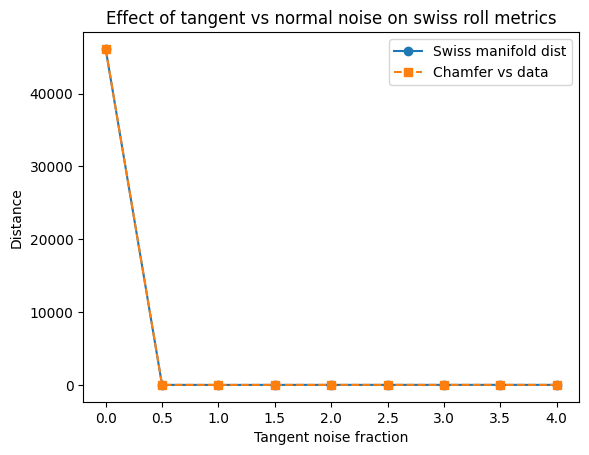

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)
df[["name", "use_manifold", "tangent_fraction", "normal_fraction", "chamfer", "swiss_dist"]]

manifold_df = df[df["use_manifold"]]

plt.figure()
plt.plot(
    manifold_df["tangent_fraction"],
    manifold_df["swiss_dist"],
    "o-",
    label="Swiss manifold dist",
)
plt.plot(
    manifold_df["tangent_fraction"],
    manifold_df["chamfer"],
    "s--",
    label="Chamfer vs data",
)
plt.xlabel("Tangent noise fraction")
plt.ylabel("Distance")
plt.legend()
plt.title("Effect of tangent vs normal noise on swiss roll metrics")
plt.show()


In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from src.generate_data import generate_dataset
from src.manifold_learning import estimate_tangent_normal_knn_pca
from src.diffusion import DiffusionExperiment

device = "cuda" if torch.cuda.is_available() else "cpu"


In [11]:
# Generate swiss roll
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=3,
    noise_sigma=0.0,
    random_state=0,
)
X = data["X"]

# Estimate tangent/normal frames
frames = estimate_tangent_normal_knn_pca(
    X,
    intrinsic_dim=2,
    n_neighbors=32,
    include_self=True,
)


In [12]:
def build_exp(tangent_fraction, normal_fraction, mixed_noise=True):
    return DiffusionExperiment(
        X=X,
        local_frames=frames,
        tangent_fraction=tangent_fraction,
        normal_fraction=normal_fraction,
        mixed_noise=mixed_noise,
        num_timesteps=1000,
        batch_size=128,
        lr=1e-3,
        device=device,
    )


In [13]:
def measure_anisotropy(exp, num_points=512, num_samples=2000):
    exp.model.eval()  # not strictly needed for noiser
    
    # pick random indices
    idx = torch.randint(0, exp.N, (num_points,), device=exp.device)
    x0  = exp.X[idx]  # (B, D)
    
    # corresponding bases
    T = exp.tangent_bases[idx]  # (B, D, d_t)
    N = exp.normal_bases[idx]   # (B, D, d_n)
    
    # storage
    all_tan_coeffs = []
    all_norm_coeffs = []
    all_norm_sq = []
    
    for _ in range(num_samples):
        eps = exp.noiser(idx, x0)  # (B, D)
        
        # project onto tangent and normal coefficient spaces
        # T: (B, D, d_t), eps: (B, D) -> coeffs_t: (B, d_t)
        coeffs_t = torch.einsum("bdk,bd->bk", T, eps)
        coeffs_n = torch.einsum("bdk,bd->bk", N, eps)
        
        all_tan_coeffs.append(coeffs_t)
        all_norm_coeffs.append(coeffs_n)
        all_norm_sq.append((eps ** 2).sum(dim=1))  # per-sample squared norm
    
    tan_coeffs = torch.cat(all_tan_coeffs, dim=0)  # (num_points * num_samples, d_t)
    norm_coeffs = torch.cat(all_norm_coeffs, dim=0)
    norm_sq = torch.cat(all_norm_sq, dim=0)        # (num_points * num_samples,)
    
    # average per-dimension variance
    var_tan = tan_coeffs.var(dim=0).mean().item()
    var_norm = norm_coeffs.var(dim=0).mean().item()
    mean_norm_sq = norm_sq.mean().item()
    
    return var_tan, var_norm, mean_norm_sq


In [14]:
ratios = np.linspace(0.0, 4.0, 9)
results = []

for r in ratios:
    print(f"Measuring for tangent_fraction={r}, normal_fraction=1.0")
    exp = build_exp(tangent_fraction=float(r), normal_fraction=1.0, mixed_noise=True)
    var_tan, var_norm, mean_norm_sq = measure_anisotropy(exp)
    results.append((r, var_tan, var_norm, mean_norm_sq))

results = np.array(results)  # shape (9, 4)


Measuring for tangent_fraction=0.0, normal_fraction=1.0
Measuring for tangent_fraction=0.5, normal_fraction=1.0
Measuring for tangent_fraction=1.0, normal_fraction=1.0
Measuring for tangent_fraction=1.5, normal_fraction=1.0
Measuring for tangent_fraction=2.0, normal_fraction=1.0
Measuring for tangent_fraction=2.5, normal_fraction=1.0
Measuring for tangent_fraction=3.0, normal_fraction=1.0
Measuring for tangent_fraction=3.5, normal_fraction=1.0
Measuring for tangent_fraction=4.0, normal_fraction=1.0


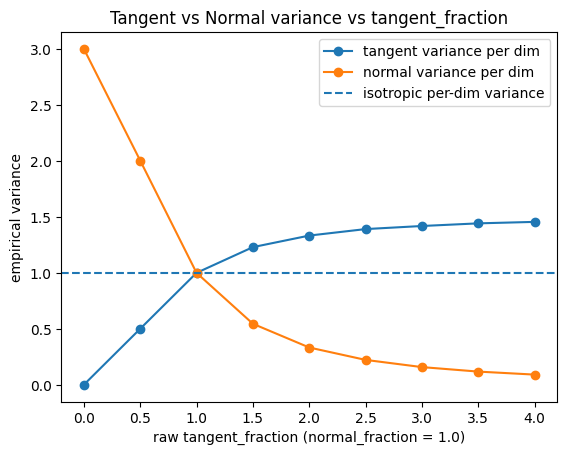

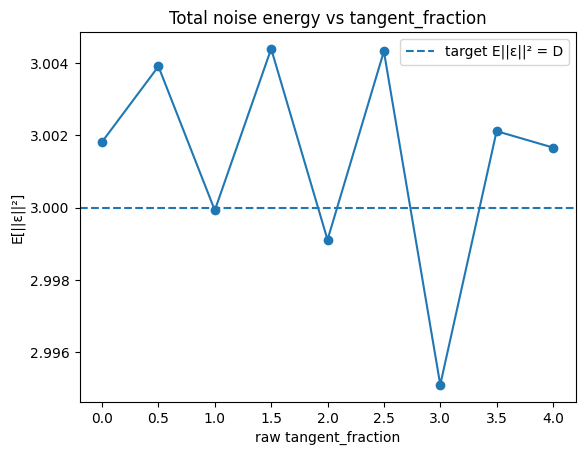

In [15]:
plt.figure()
plt.plot(results[:, 0], results[:, 1], marker='o', label='tangent variance per dim')
plt.plot(results[:, 0], results[:, 2], marker='o', label='normal variance per dim')
plt.axhline(1.0, linestyle='--', label='isotropic per-dim variance')
plt.xlabel("raw tangent_fraction (normal_fraction = 1.0)")
plt.ylabel("empirical variance")
plt.legend()
plt.title("Tangent vs Normal variance vs tangent_fraction")
plt.show()

plt.figure()
plt.plot(results[:, 0], results[:, 3], marker='o')
plt.axhline(X.shape[1], linestyle='--', label='target E||ε||² = D')
plt.xlabel("raw tangent_fraction")
plt.ylabel("E[||ε||²]")
plt.legend()
plt.title("Total noise energy vs tangent_fraction")
plt.show()


### Visualizing The Noise?

In [11]:
import numpy as np
import torch

import plotly.graph_objects as go

from src.generate_data import generate_dataset
from src.manifold_learning import estimate_tangent_normal_knn_pca
from src.diffusion import DiffusionExperiment

device = "cuda" if torch.cuda.is_available() else "cpu"
device

# Generate swiss roll data
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=3,
    noise_sigma=0.0,
    random_state=0,
)
X = data["X"]  # (N, 3)

# Estimate tangent/normal frames
frames = estimate_tangent_normal_knn_pca(
    X,
    intrinsic_dim=2,
    n_neighbors=32,
    include_self=True,
)

def build_exp(tangent_fraction, normal_fraction, mixed_noise=True):
    exp = DiffusionExperiment(
        X=X,
        local_frames=frames,
        tangent_fraction=tangent_fraction,
        normal_fraction=normal_fraction,
        mixed_noise=mixed_noise,
        num_timesteps=1000,
        batch_size=128,
        lr=1e-3,
        device=device,
    )
    return exp

def sample_noised_cloud(exp, point_idx, num_samples=2000):
    """
    exp: DiffusionExperiment
    point_idx: int, index in [0, N)
    num_samples: number of noisy samples to draw around that point
    """
    exp.model.eval()  # irrelevant for noiser, but fine

    idx = torch.tensor([point_idx], device=exp.device, dtype=torch.long)
    x0 = exp.X[idx]  # (1, D)

    all_noised = []

    for _ in range(num_samples):
        eps = exp.noiser(idx, x0)   # (1, D)
        x_noised = x0 + eps         # (1, D)
        all_noised.append(x_noised.detach().cpu().numpy())

    all_noised = np.concatenate(all_noised, axis=0)  # (num_samples, D)
    x0_np = x0.detach().cpu().numpy().reshape(-1)    # (D,)
    return x0_np, all_noised

def plot_noise_cloud_3d_plotly(x0, cloud, title=None):
    """
    x0: (3,) numpy array — the original point
    cloud: (num_samples, 3) — noised samples
    """
    fig = go.Figure()

    # noisy samples
    fig.add_trace(
        go.Scatter3d(
            x=cloud[:, 0],
            y=cloud[:, 1],
            z=cloud[:, 2],
            mode="markers",
            marker=dict(
                size=2,
                opacity=0.2,
            ),
            name="noisy samples",
        )
    )

    # original point
    fig.add_trace(
        go.Scatter3d(
            x=[x0[0]],
            y=[x0[1]],
            z=[x0[2]],
            mode="markers",
            marker=dict(
                size=6,
                symbol="star",
            ),
            name="x0",
        )
    )

    fig.update_layout(
        title=title or "Noise cloud",
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="z",
            aspectmode="data",
        ),
        showlegend=True,
    )

    fig.show()

def plot_noise_with_frames_plotly(exp, point_idx, cloud, title=None, scale=1.0):
    """
    exp: DiffusionExperiment
    point_idx: index of the point
    cloud: (num_samples, 3) numpy array
    scale: how long to draw the basis vectors
    """
    # get base point + frames
    idx = torch.tensor([point_idx], device=exp.device, dtype=torch.long)
    x0 = exp.X[idx].detach().cpu().numpy().reshape(-1)          # (3,)
    T = exp.tangent_bases[idx].detach().cpu().numpy()[0]        # (D, d_t)
    N = exp.normal_bases[idx].detach().cpu().numpy()[0]         # (D, d_n)

    fig = go.Figure()

    # noisy samples
    fig.add_trace(
        go.Scatter3d(
            x=cloud[:, 0],
            y=cloud[:, 1],
            z=cloud[:, 2],
            mode="markers",
            marker=dict(
                size=2,
                opacity=0.2,
            ),
            name="noisy samples",
        )
    )

    # base point
    fig.add_trace(
        go.Scatter3d(
            x=[x0[0]],
            y=[x0[1]],
            z=[x0[2]],
            mode="markers",
            marker=dict(
                size=3,
                symbol="x",
            ),
            name="x0",
        )
    )

    # tangent vectors (as line segments)
    for j in range(T.shape[1]):
        v = T[:, j] * scale
        fig.add_trace(
            go.Scatter3d(
                x=[x0[0], x0[0] + v[0]],
                y=[x0[1], x0[1] + v[1]],
                z=[x0[2], x0[2] + v[2]],
                mode="lines+markers",
                marker=dict(size=3),
                name=f"tangent_{j}",
            )
        )

    # normal vectors
    for j in range(N.shape[1]):
        v = N[:, j] * scale
        fig.add_trace(
            go.Scatter3d(
                x=[x0[0], x0[0] + v[0]],
                y=[x0[1], x0[1] + v[1]],
                z=[x0[2], x0[2] + v[2]],
                mode="lines+markers",
                marker=dict(size=3),
                name=f"normal_{j}",
            )
        )

    fig.update_layout(
        title=title or "Noise cloud with tangent/normal frames",
        scene=dict(
            xaxis_title="x",
            yaxis_title="y",
            zaxis_title="z",
            aspectmode="data",
        ),
        showlegend=True,
    )

    fig.show()
    
    # pick a single point on the swiss roll
point_idx = 1234  # or np.random.randint(0, X.shape[0])

# (a) pure normal noise: tangent_fraction = 0
exp_norm = build_exp(tangent_fraction=0.0, normal_fraction=1.0, mixed_noise=True)
x0_norm, cloud_norm = sample_noised_cloud(exp_norm, point_idx, num_samples=3000)
plot_noise_with_frames_plotly(
    exp_norm,
    point_idx,
    cloud_norm,
    title="Pure normal noise (tangent_fraction = 0.0)",
    scale=1.0,
)

# (b) isotropic: tangent_fraction = normal_fraction = 1
exp_iso = build_exp(tangent_fraction=1.0, normal_fraction=1.0, mixed_noise=True)
x0_iso, cloud_iso = sample_noised_cloud(exp_iso, point_idx, num_samples=3000)
plot_noise_with_frames_plotly(
    exp_iso,
    point_idx,
    cloud_iso,
    title="Isotropic noise (tangent_fraction = 1.0, normal_fraction = 1.0)",
    scale=1.0,
)

# (c) tangent-heavy: tangent_fraction = 4
exp_tan = build_exp(tangent_fraction=10.0, normal_fraction=1.0, mixed_noise=True)
x0_tan, cloud_tan = sample_noised_cloud(exp_tan, point_idx, num_samples=3000)
plot_noise_with_frames_plotly(
    exp_tan,
    point_idx,
    cloud_tan,
    title="Tangent-heavy noise (tangent_fraction = 10.0 normal_fraction = 1.0)",
    scale=1.0,
)


# (c) tangent-heavy: tangent_fraction = 4
exp_tan = build_exp(tangent_fraction=1.0, normal_fraction=10.0, mixed_noise=True)
x0_tan, cloud_tan = sample_noised_cloud(exp_tan, point_idx, num_samples=3000)
plot_noise_with_frames_plotly(
    exp_tan,
    point_idx,
    cloud_tan,
    title="Normal-heavy noise (tangent_fraction = 1.0 normal_fraction = 10.0)",
    scale=1.0,
)

# pick a single point on the swiss roll
point_idx = 1234  # or np.random.randint(0, X.shape[0])

In [12]:
import numpy as np
import torch
import plotly.graph_objects as go

from src.generate_data import generate_dataset
from src.manifold_learning import estimate_tangent_normal_knn_pca
from src.diffusion import DiffusionExperiment

device = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# 1) Data + frames
# ----------------------------
data = generate_dataset(
    name="swiss_roll",
    n_samples=5000,
    embed_dim=3,
    noise_sigma=0.0,
    random_state=0,
)
X = data["X"]  # (N, 3)

frames = estimate_tangent_normal_knn_pca(
    X,
    intrinsic_dim=2,     # d_t = 2
    n_neighbors=32,
    include_self=True,
)

# ----------------------------
# 2) f -> (a0, b0) conversion
# ----------------------------
def raw_weights_from_f(f: float, d_t: int, d_n: int, b0: float = 1.0):
    """
    Choose raw weights (a0, b0) such that the tangent variance fraction is f:
        f = (d_t * a0^2) / (d_t * a0^2 + d_n * b0^2)

    We fix b0=1 by default and solve for a0.
    """
    if not (0.0 <= f <= 1.0):
        raise ValueError(f"f must be in [0,1], got {f}")
    if f == 0.0:
        return 0.0, b0
    if f == 1.0:
        return 1e6, b0  # "almost" tangent-only (avoid literal inf)

    a0_sq = (f * d_n * (b0 ** 2)) / ((1.0 - f) * d_t)
    a0 = float(np.sqrt(a0_sq))
    return a0, b0

def build_exp_from_f(f: float, mixed_noise: bool = True):
    d_t = frames.intrinsic_dim          # 2
    D = X.shape[1]                      # 3
    d_n = D - d_t                       # 1

    a0, b0 = raw_weights_from_f(f, d_t=d_t, d_n=d_n, b0=1.0)

    exp = DiffusionExperiment(
        X=X,
        local_frames=frames,
        tangent_fraction=a0,     # raw a0
        normal_fraction=b0,      # raw b0
        mixed_noise=mixed_noise,
        num_timesteps=1000,
        batch_size=128,
        lr=1e-3,
        device=device,
    )
    return exp, (a0, b0)

# ----------------------------
# 3) Sampling a local noise cloud
# ----------------------------
def sample_noised_cloud(exp, point_idx: int, num_samples: int = 3000):
    idx = torch.tensor([point_idx], device=exp.device, dtype=torch.long)
    x0 = exp.X[idx]  # (1, D)

    clouds = []
    for _ in range(num_samples):
        eps = exp.noiser(idx, x0)       # (1, D)
        x_noised = (x0 + eps)           # visualize raw noise cloud
        clouds.append(x_noised.detach().cpu().numpy())

    cloud = np.concatenate(clouds, axis=0)  # (num_samples, D)
    x0_np = x0.detach().cpu().numpy().reshape(-1)
    return x0_np, cloud

def plot_noise_with_frames_plotly(exp, point_idx, cloud, title=None, scale=1.0):
    idx = torch.tensor([point_idx], device=exp.device, dtype=torch.long)
    x0 = exp.X[idx].detach().cpu().numpy().reshape(-1)          # (3,)
    T = exp.tangent_bases[idx].detach().cpu().numpy()[0]        # (D, d_t)
    N = exp.normal_bases[idx].detach().cpu().numpy()[0]         # (D, d_n)

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=cloud[:, 0], y=cloud[:, 1], z=cloud[:, 2],
        mode="markers",
        marker=dict(size=2, opacity=0.2),
        name="noisy samples",
    ))

    fig.add_trace(go.Scatter3d(
        x=[x0[0]], y=[x0[1]], z=[x0[2]],
        mode="markers",
        marker=dict(size=4, symbol="x"),
        name="x0",
    ))

    # tangent basis vectors
    for j in range(T.shape[1]):
        v = T[:, j] * scale
        fig.add_trace(go.Scatter3d(
            x=[x0[0], x0[0] + v[0]],
            y=[x0[1], x0[1] + v[1]],
            z=[x0[2], x0[2] + v[2]],
            mode="lines+markers",
            marker=dict(size=3),
            name=f"tangent_{j}",
        ))

    # normal basis vectors
    for j in range(N.shape[1]):
        v = N[:, j] * scale
        fig.add_trace(go.Scatter3d(
            x=[x0[0], x0[0] + v[0]],
            y=[x0[1], x0[1] + v[1]],
            z=[x0[2], x0[2] + v[2]],
            mode="lines+markers",
            marker=dict(size=3),
            name=f"normal_{j}",
        ))

    fig.update_layout(
        title=title or "Noise cloud with tangent/normal frames",
        scene=dict(
            xaxis_title="x", yaxis_title="y", zaxis_title="z",
            aspectmode="data",
        ),
        showlegend=True,
    )
    fig.show()

# ----------------------------
# 4) Make the three plots
# ----------------------------
point_idx = 1234

D = X.shape[1]
d_t = frames.intrinsic_dim
f_iso = d_t / D  # isotropic baseline tangent variance fraction (2/3 in 3D)

configs = [
    ("Normal-heavy", 0.10),     # mostly normal variance
    ("Isotropic",    f_iso),    # exactly isotropic in your setup
    ("Tangent-heavy", 0.90),    # mostly tangent variance
]

for name, f in configs:
    exp, (a0, b0) = build_exp_from_f(f)
    x0, cloud = sample_noised_cloud(exp, point_idx, num_samples=3000)

    title = (
        f"{name} noise | f={f:.3f} "
        f"(raw a0={a0:.3f}, b0={b0:.3f})"
    )
    plot_noise_with_frames_plotly(exp, point_idx, cloud, title=title, scale=1.0)


In [17]:
def raw_weights_from_f(f, d_t=2, d_n=1):
    """
    Given tangent variance fraction f in [0,1],
    return raw (a0, b0) weights before normalization.
    We fix b0 = 1 and solve for a0.
    """
    if f <= 0:
        return 0.0, 1.0
    if f >= 1:
        return 1.0, 0.0
    
    a0_sq = (f * d_n) / (d_t * (1 - f))
    a0 = np.sqrt(a0_sq)
    b0 = 1.0
    return a0, b0

# target variance fractions
f_values = [0.1, 2/3, 0.95]
labels = [
    "Normal-heavy noise",
    "Isotropic noise",
    "Tangent-heavy noise",
]

experiments = []

for f in f_values:
    a0, b0 = raw_weights_from_f(f)
    exp = build_exp(
        tangent_fraction=a0,
        normal_fraction=b0,
        mixed_noise=True,
    )
    experiments.append((f, exp))


point_idx = 1234
num_samples = 3000

clouds = []
x0 = None

for f, exp in experiments:
    x0_np, cloud = sample_noised_cloud(exp, point_idx, num_samples)
    x0 = x0_np
    clouds.append(cloud)

from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(
    rows=1,
    cols=3,
    specs=[[{"type": "scene"}]*3],
    subplot_titles=[
        rf"{labels[0]}<br>f={f_values[0]:.2f}",
        rf"{labels[1]}<br>f={f_values[1]:.2f}",
        rf"{labels[2]}<br>f={f_values[2]:.2f}",
    ],
)

for i, cloud in enumerate(clouds):
    # noisy samples
    fig.add_trace(
        go.Scatter3d(
            x=cloud[:, 0],
            y=cloud[:, 1],
            z=cloud[:, 2],
            mode="markers",
            marker=dict(size=2, opacity=0.15),
            showlegend=False,
        ),
        row=1,
        col=i+1,
    )
    
    # base point
    fig.add_trace(
        go.Scatter3d(
            x=[x0[0]],
            y=[x0[1]],
            z=[x0[2]],
            mode="markers",
            marker=dict(size=6, symbol="x"),
            showlegend=False,
        ),
        row=1,
        col=i+1,
    )

fig.update_layout(
    title="Manifold-Aware Diffusion Noise: Effect of Tangent Variance Fraction",
    height=500,
    width=1200,
    scene=dict(aspectmode="data"),
    scene2=dict(aspectmode="data"),
    scene3=dict(aspectmode="data"),
)

fig.show()
